## IMPORTS

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time
import os
import pandas as pd

## HYPERPARAMS

In [2]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
dataroot = '../storage/data/dogscats'
saveroot = '../storage/GAN_Images/'
test_number = 1

train_dataroot = os.path.join(dataroot, 'train/dogs')
valid_dataroot = os.path.join(dataroot, 'valid/dogs')

batch_size = 32
workers = 2

image_size = 64
nz = 100
ngf = 64
ndf = 64
nc = 3 

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(image_size),
    torchvision.transforms.CenterCrop(image_size),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

lr = 2e-4
beta1 = 0.5
beta2 = 0

num_epochs = 150
k = 1

## DATASET ANALYSIS

In [4]:
# imgs = list(os.listdir(train_dataroot))

# H = []
# W = []
# C = []

# for i in imgs:
#     i = os.path.join(train_dataroot, i)
#     i = np.array(Image.open(i))
#     h, w, c = i.shape
#     H.append(h)
#     W.append(w)
#     C.append(c)

In [5]:
# H = pd.Series(H)
# W = pd.Series(W)
# print(f"MEAN: {H.mean()} {W.mean()}")
# print(f"MEDIAN: {H.median()} {W.median()}")
# print(f"MODE: {H.mode()} {W.mode()}")

In [6]:
# img = os.path.join(train_dataroot, (os.listdir(train_dataroot)[5]))
# img = transforms(Image.open(img))
# img.shape

## DATASETS

In [7]:
class DogsDataset(torch.utils.data.Dataset):
    def __init__(self, dataroot, transform):
        self.dataroot = dataroot
        self.transform = transform
        self.images = list(sorted(os.listdir(dataroot)))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = os.path.join(self.dataroot, self.images[index])
        image = Image.open(image)
        if self.transform:
            x = self.transform(image)
        return x

In [8]:
train_ds = DogsDataset(train_dataroot, transforms)
valid_ds = DogsDataset(valid_dataroot, transforms)

In [9]:
len(train_ds), len(valid_ds)

(11500, 1000)

In [10]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size, True, num_workers=workers)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size, False, num_workers=workers)

In [30]:
def visualizeImages(images):
    images.to(device)
    plt.figure(figsize=(16,16))
    grid = torchvision.utils.make_grid(images, nrow=8, normalize=True)
    plt.imshow(grid.detach().cpu().permute(1,2,0))

torch.Size([32, 3, 64, 64])


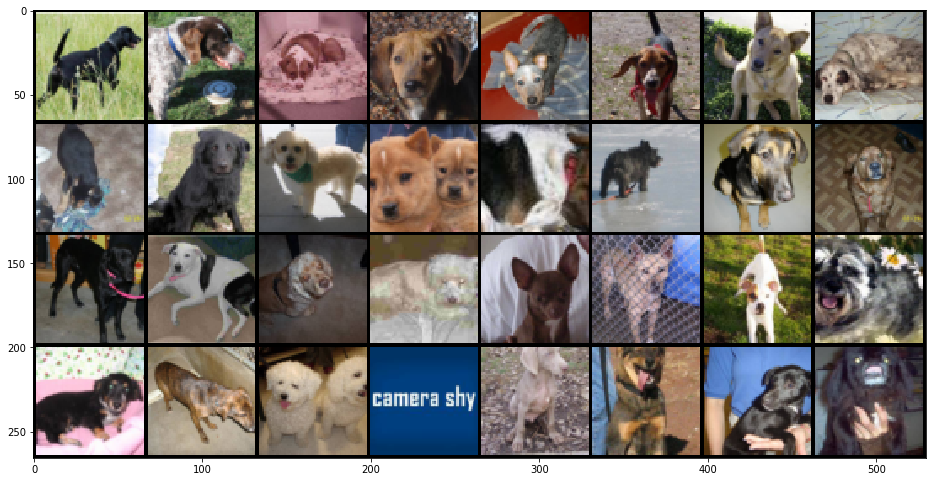

In [31]:
for xb in train_dl:
    print(xb.shape)
    visualizeImages(xb)
    break

## MODEL

In [13]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            torch.nn.BatchNorm2d(ngf*8),
            torch.nn.ReLU(True),
            
            torch.nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ngf*4),
            torch.nn.ReLU(True),
            
            torch.nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ngf*2),
            torch.nn.ReLU(True),
            
            torch.nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ngf),
            torch.nn.ReLU(True),
            
            torch.nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            torch.nn.Tanh(),
        )
        
    def forward(self, input):
        return self.main(input)

In [14]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = torch.nn.Sequential(
            torch.nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            torch.nn.LeakyReLU(0.2, inplace=True),
            
            torch.nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf*2),
            torch.nn.LeakyReLU(0.2, inplace=True),
            
            torch.nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf*4),
            torch.nn.LeakyReLU(0.2, inplace=True),
            
            torch.nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf*8),
            torch.nn.LeakyReLU(0.2, inplace=True),
            
            torch.nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            torch.nn.Sigmoid()
        )
        
    def forward(self, input):
        return self.main(input).view(-1,1)

In [15]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

In [16]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

## OPTIMIZERS AND LOSS FUNCTION

In [17]:
criterion = torch.nn.BCELoss()

opt_d = torch.optim.Adam(discriminator.parameters(), lr, betas=(beta1, 0.999))
opt_g = torch.optim.Adam(generator.parameters(), lr, betas=(beta1, 0.999))

In [18]:
fixed_noise = torch.randn(batch_size, nz, 1, 1).to(device)

real_labels = torch.ones(batch_size, 1).to(device)
fake_labels = torch.zeros(batch_size, 1).to(device)
print(real_labels.dtype, fake_labels.shape)

torch.float32 torch.Size([32, 1])


## PRE-TRAIN

In [19]:
sample_img = generator(torch.randn(batch_size,nz, 1, 1).to(device)).detach()
print(sample_img.shape)

sample_out = discriminator(sample_img).detach()
print(sample_out.shape)

loss = criterion(sample_out, real_labels)
print(loss)

torch.Size([32, 3, 64, 64])
torch.Size([32, 1])
tensor(0.6911, device='cuda:0')


In [20]:
for img in train_dl:
    img = img.to(device)
    out = discriminator(img).detach()
    loss = criterion(out, real_labels)
    print(xb.shape, xb.dtype)
    print(out.shape)
    print(loss)
    break

torch.Size([32, 3, 64, 64]) torch.float32
torch.Size([32, 1])
tensor(0.8537, device='cuda:0')


## TRAIN

In [21]:
def train_discriminator(real_images):
    opt_d.zero_grad()
        
    fake_images = generator(torch.randn(batch_size, nz, 1, 1).to(device)).detach()
        
    real_outputs = discriminator(real_images)
    fake_outputs = discriminator(fake_images)
        
    real_loss = criterion(real_outputs, real_labels)
    fake_loss = criterion(fake_outputs, fake_labels)
    real_loss.backward()
    fake_loss.backward()
        
    opt_d.step()
        
    return real_loss + fake_loss

def train_generator():
    opt_g.zero_grad()
        
    outputs = discriminator(generator(torch.randn(batch_size, nz, 1,1).to(device)))
        
    loss = criterion(outputs, real_labels)
    loss.backward()
        
    opt_g.step()
        
    return loss

In [22]:
start_time = time.time()

loss_D = []
loss_G = []

for epoch in range(num_epochs):    
    epoch += 1
    loss_d = 0.0
    loss_g = 0.0
    
    for i, xb in enumerate(train_dl):
        xb = xb.to(device)
        
        if i == 300:
            break
        
        for _ in range(k):
            loss_d += train_discriminator(xb)
        loss_g += train_generator()
        
    loss_D.append(loss_d/i)
    loss_G.append(loss_g/i)
    
    if epoch % 1 == 0:
        print(f"{epoch}/{num_epochs} | G_LOSS: {loss_g/i:.4f} | D_LOSS: {loss_d/i:.4f} | TIME: {time.time() - start_time:.0f}sec")
        sample = generator(fixed_noise).detach()
        grid = torchvision.utils.make_grid(sample.view(-1, 3, image_size, image_size), nrow=8, pad_value=1, normalize=True)   
        torchvision.utils.save_image(grid.detach().cpu(), os.path.join(saveroot, '20210121_DCGAN_DOGS_{}_{}.jpg'.format(test_number, str(epoch).zfill(3))))        
    
print(f"TOTAL TIME: {time.time() - start_time:.0f}sec")

1/150 | G_LOSS: 8.1626 | D_LOSS: 0.5995 | TIME: 21sec
2/150 | G_LOSS: 5.0294 | D_LOSS: 0.6216 | TIME: 46sec
3/150 | G_LOSS: 5.2550 | D_LOSS: 0.5123 | TIME: 73sec
4/150 | G_LOSS: 4.7763 | D_LOSS: 0.4326 | TIME: 98sec
5/150 | G_LOSS: 4.1710 | D_LOSS: 0.6122 | TIME: 123sec
6/150 | G_LOSS: 3.9222 | D_LOSS: 0.6267 | TIME: 148sec
7/150 | G_LOSS: 3.8866 | D_LOSS: 0.6214 | TIME: 166sec
8/150 | G_LOSS: 3.8430 | D_LOSS: 0.6786 | TIME: 183sec
9/150 | G_LOSS: 3.2725 | D_LOSS: 0.6846 | TIME: 201sec
10/150 | G_LOSS: 3.4159 | D_LOSS: 0.6261 | TIME: 218sec
11/150 | G_LOSS: 3.4854 | D_LOSS: 0.6061 | TIME: 235sec
12/150 | G_LOSS: 3.4123 | D_LOSS: 0.5426 | TIME: 252sec
13/150 | G_LOSS: 3.3754 | D_LOSS: 0.5854 | TIME: 270sec
14/150 | G_LOSS: 3.3370 | D_LOSS: 0.6131 | TIME: 288sec
15/150 | G_LOSS: 3.0182 | D_LOSS: 0.6466 | TIME: 306sec
16/150 | G_LOSS: 3.0133 | D_LOSS: 0.6317 | TIME: 324sec
17/150 | G_LOSS: 3.0095 | D_LOSS: 0.6419 | TIME: 341sec
18/150 | G_LOSS: 3.1319 | D_LOSS: 0.6123 | TIME: 359sec
19/15

## EVALUATE

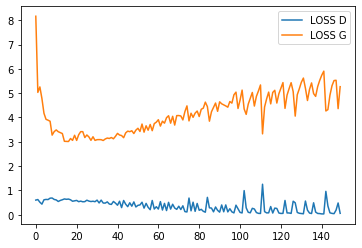

In [28]:
plt.figure()

plt.plot(loss_D, label='LOSS D')
plt.plot(loss_G, label='LOSS G')
plt.savefig('./20210121_DCGAN_DOGS_{}.png'.format(test_number))
plt.legend()
plt.show()

## TEST

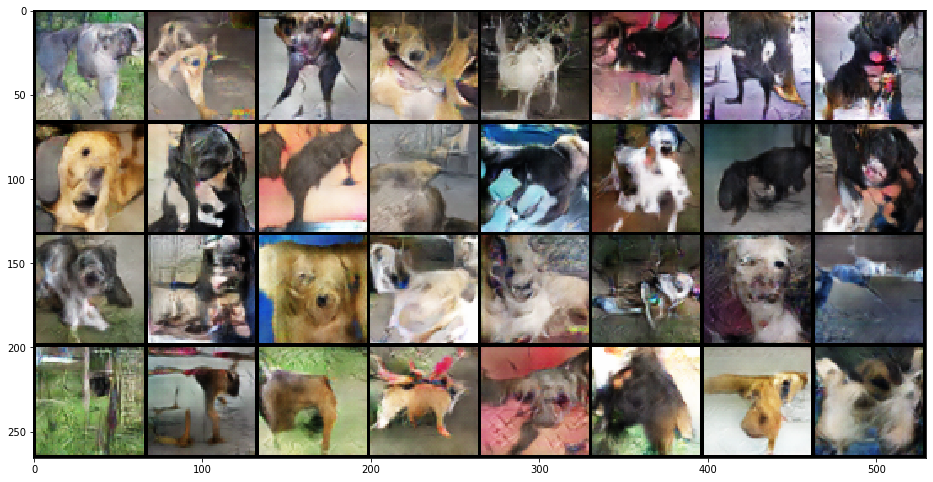

In [42]:
sample_img = generator(torch.randn(batch_size,nz, 1, 1).to(device)).detach()
visualizeImages(sample_img)

## EXPORTS

In [27]:
torch.save(generator.state_dict(), './20210121_DCGAN_DOGS_G_{}.pt'.format(test_number))
torch.save(discriminator.state_dict(), './20210121_DCGAN_DOGS_D_{}.pt'.format(test_number))